In [1]:
"""
Created By    : Taylor McHone
Creation Date : 02 December 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
Perform a univariate statistical objective analysis of 500 mb heights 
using a Barnes analysis and the Schlatter model.

"""
__author__    = "Taylor McHone"
__contact__   = "taylor.mchone@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                

In [3]:
### Read in observations ###
df = pd.read_csv("RAOBs_201903131200.txt", sep=",", names=['station', 'lat', 'lon', 'height', 'wind_direction', 'wind_speed'])

#convert lat/lon to radians and add to df
df['lat_radians']=df['lat']*(np.pi/180)
df['lon_radians']=df['lon']*(np.pi/180)
df.head()

,station,lat,lon,height,wind_direction,wind_speed,lat_radians,lon_radians
0,CWPL,51.47,-90.2,5460.0,285.0,29.0,0.898321,-1.574287
1,CWQI,43.83,-66.0,5540.0,325.0,41.0,0.764978,-1.151917
2,CWSE,53.55,-113.9,5360.0,280.0,12.0,0.934624,-1.987930
3,CYAH,53.75,-73.6,5340.0,300.0,70.0,0.938114,-1.284562
4,CYBK,64.30,-96.0,5220.0,95.0,17.0,1.122247,-1.675516


In [17]:
#Create functions

def weight(dik):  #returns weight for a given distance
    return np.exp(-((dik)**2)/k_d)

#bilinear interpolation #
def bilin_interp(x, y, a_mx):
    # (x,y) is location to interpolate to
    # a_mx is an analysis matrix
    
    x_rel = x - np.floor(x) #define relative x and y coords within a square of points (0,0), (0,1), (1,0) and (1,1)
    y_rel = y - np.floor(y)
   
    z1 = a_mx[int(np.floor(y))][int(np.floor(x))] #find analysis values from analyis matrix
    z2 = a_mx[int(np.ceil(y))][int(np.floor(x))]
    z3 = a_mx[int(np.ceil(y))][int(np.ceil(x))]
    z4 = a_mx[int(np.floor(y))][int(np.ceil(x))]
 
    answer = (x_rel-1)*(y_rel-1)*z1 - x_rel*(y_rel-1)*z2 + x_rel*y_rel*z3 - (x_rel-1)*y_rel*z4  #bilinear interpolation equation
    return answer

def schlatter(s): #returns correlation value for a given distance
    rho = 0.95 * np.exp(-new_val * (s**2))
    rho[s < 1e-3] = 1 #catching that silly little situation
    return rho

In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#find grid points
x_step = 18.9 + np.arange(22)*1.27 #18.9,-6.3 starting pts, 22,28 number of axis pts, 1.27cm between pts
y_step = -6.3 + np.arange(28)*1.27
xx,yy = np.meshgrid(x_step,y_step)

#convert grid points to lat/lon

#known vals
map_proj=1/(15e6)
rho = 6371 * 1e5
lambda_o=-115
phi_o = 60 * (np.pi/180)
phi_new = 40 * (np.pi/180)

#transformation eqs
x2lon = np.arctan(yy/xx) * (180/np.pi) + lambda_o
y2lat = (180/np.pi) * ((np.pi/2) - (2*np.arctan(np.sqrt((xx/map_proj)**2+(yy/map_proj)**2)/(rho*(1+np.sin(phi_o))))))

### convert obs lat/long to x,y ###
#assign vars
phi = df['lat_radians']
lambdy = df['lon_radians']

#solve for image scale factor and radius of lat circle
sigma = (1+np.sin(phi_o))/(1+np.sin(phi))
r = rho * sigma * np.cos(phi) * map_proj


phi_eq = (1+np.sin(phi_o))/(1+np.sin(phi_new)) #new image scale factor
new_val = 1.24/phi_eq
print(new_val)

#lam = deviation of lon from standard lon
lam = lambdy - (lambda_o*np.pi/180)
x = r*np.cos(lam)#*map_proj
y = r*np.sin(lam)#*map_proj

1.0916553611113793


In [5]:
#calculating d_ik and weights

#define constants
k_d = 10.8844524 #cm^2
r_e = 12.7775892 #radius of influence in cm

d_iks = np.zeros((28,22,135))
#subtract every ob point from each analysis point
for j in range(len(xx)): 
    for k in range(len(xx[j])):
            xd = xx[j,k] - x # single grid point loc minus all observation locs
            yd= yy[j,k] - y

        #distance formula
            d_ik = ((xd**2 + yd**2)**.5)  #135x1 array containing distance between analysis and observation locations
            d_iks[j,k]=d_ik 
            
            
#if d_ik < r_e calculate the weight

W = np.exp(-((d_iks)**2)/k_d) #weight formula on d_ik array
want = d_iks<=r_e #boolean array
W = np.clip(W*want, 0, 10) #change -0.0 values to 0, left with all weights as a 28x22x135 array 

#first pass
f_o = np.array(df['height']) #observation values
f_a1 = np.zeros((28,22)) #background values

for i in range(len(W)):
    for j in range(len(W[0])):
        faik = W[i][j] * f_o #multiply weight for a grid point by ob values
        fa_num = np.sum(faik)
        weight_sum = np.sum(W[i][j])
        
        fa = fa_num/weight_sum
        f_a1[i][j] = fa
        
f_bi = f_a1

In [7]:
#getting f_B at r_k (ob locs)

#find analysis values at observation points from pass 1
#check if ob loc is in grid, if yes-->bilin interp and if not-->reverse barnes
f_bk = np.zeros(135)
indx = (x-18.9)/1.27
indy = (y+6.3)/1.27

for idx in range(135): #for each observation point
    if indx[idx]>=0 and indy[idx]>=0 and indx[idx]<21 and indy[idx]<27: #if observation point is in grid
        fark = bilin_interp(indx[idx], indy[idx], f_a1) #perform bilinear interp to find analysis value at that point
        
      
    else: #if ob not in grid
        xd = x[idx] - xx #ob point - grid points
        yd = y[idx] - yy
        
        #distance formula
        d_ik = ((xd**2 + yd**2)**.5) #28x22
        weights=np.zeros(xx.shape)
        want = np.where(d_ik<=r_e)
        
        for j in want[0]:
            for k in want[1]:
                weights[j,k] = weight(d_ik[j,k])
    
        

        fark = np.sum(weights*f_a1)/np.sum(weights)
    f_bk[idx] = fark 

C:\Users\taylo\AppData\Local\Temp\ipykernel_25428\4076843219.py:29: RuntimeWarning: invalid value encountered in double_scalars
  fark = np.sum(weights*f_a1)/np.sum(weights)


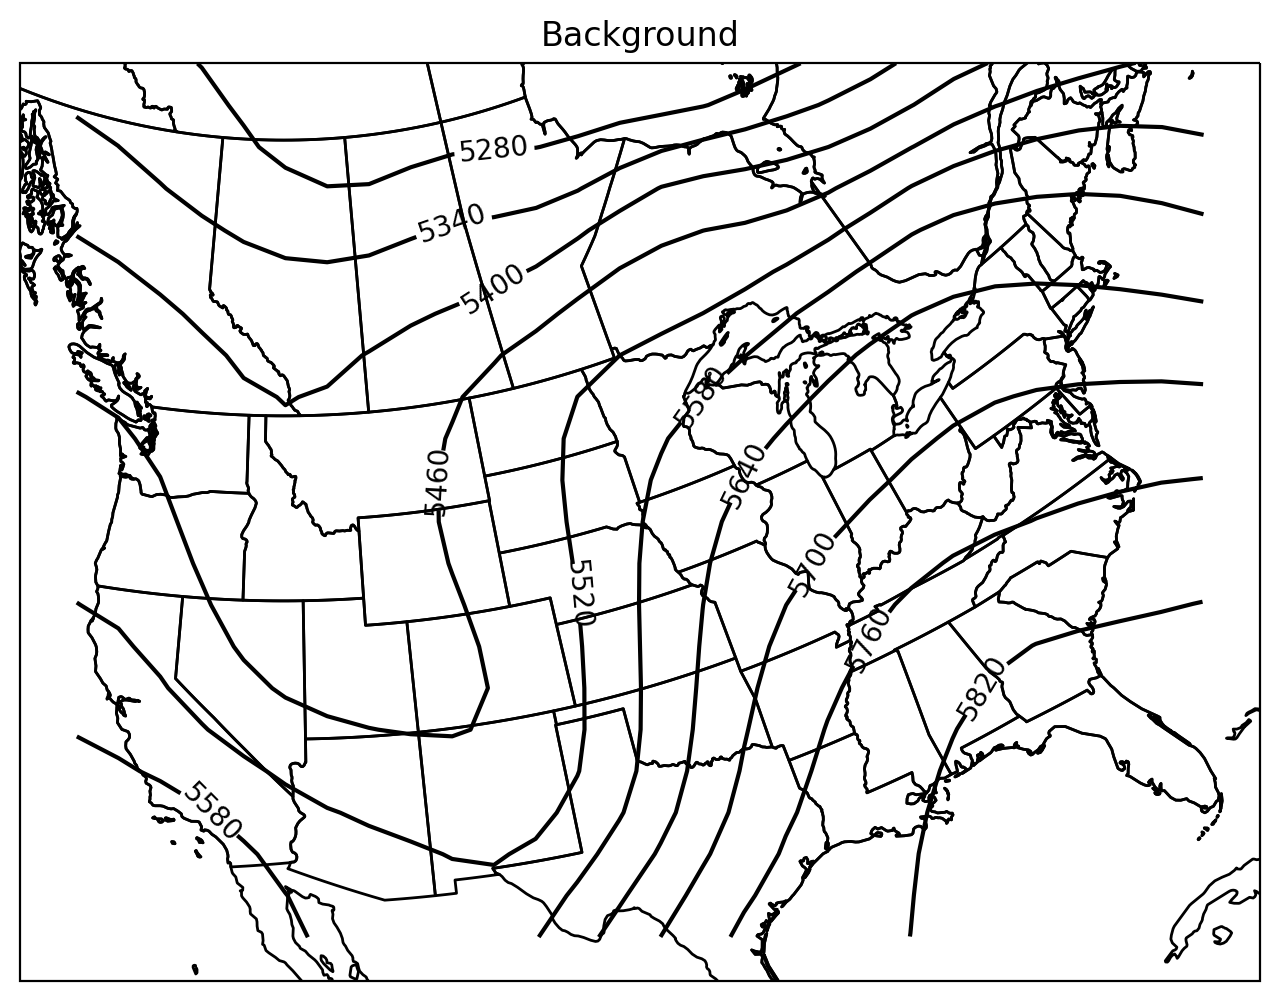

In [8]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,f_a1,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Background')

plt.show()

In [21]:
#big loopy to find analysis matrix

N = [2,4,10] #number of stations
analysis_mx = np.zeros((28,22,len(N)))
for idx in range(len(N)):
    n = N[idx]
    for i in range(len(xx)): #for each xval and yval in grid
        for j in range(len(xx[i])):
            xd = xx[i,j] - x #grid point minus ob points
            yd = yy[i,j] - y
            distance = ((xd**2 + yd**2)**.5)*0.15 #1x135 array
            sorted_idx = np.argsort(distance) #indices for distances from smallest to largest
            
            diks = np.array(distance[sorted_idx[:n]]) #distances between a grid point and ob points
            xob_locs = np.array(x[sorted_idx[:n]])
            yob_locs = np.array(y[sorted_idx[:n]])
            heights = np.array(df['height'][sorted_idx[:n]])
            b_k = np.array(f_bk[sorted_idx[:n]])
            
            #correlations between ob points :(
            correlations_ob = np.zeros((n,n)) #between obs and obs
            correlations_oba = np.zeros((n,n)) #between obs and analysis points
            
            for k in range(len(xob_locs)):
                d_ik = ((xob_locs[k] - xob_locs)**2 + (yob_locs[k] - yob_locs)**2)**0.5 #distance between an ob and all other obs
                correlations_ob[k] = schlatter(d_ik*0.15) 
                
                
            correlations_oba = np.matrix(schlatter(diks)).T
            weights = np.array(np.linalg.inv(correlations_ob)*(correlations_oba)).flatten()
            
            analysis_mx[i,j,idx] = f_a1[i,j] + np.nansum(weights*(heights-b_k))

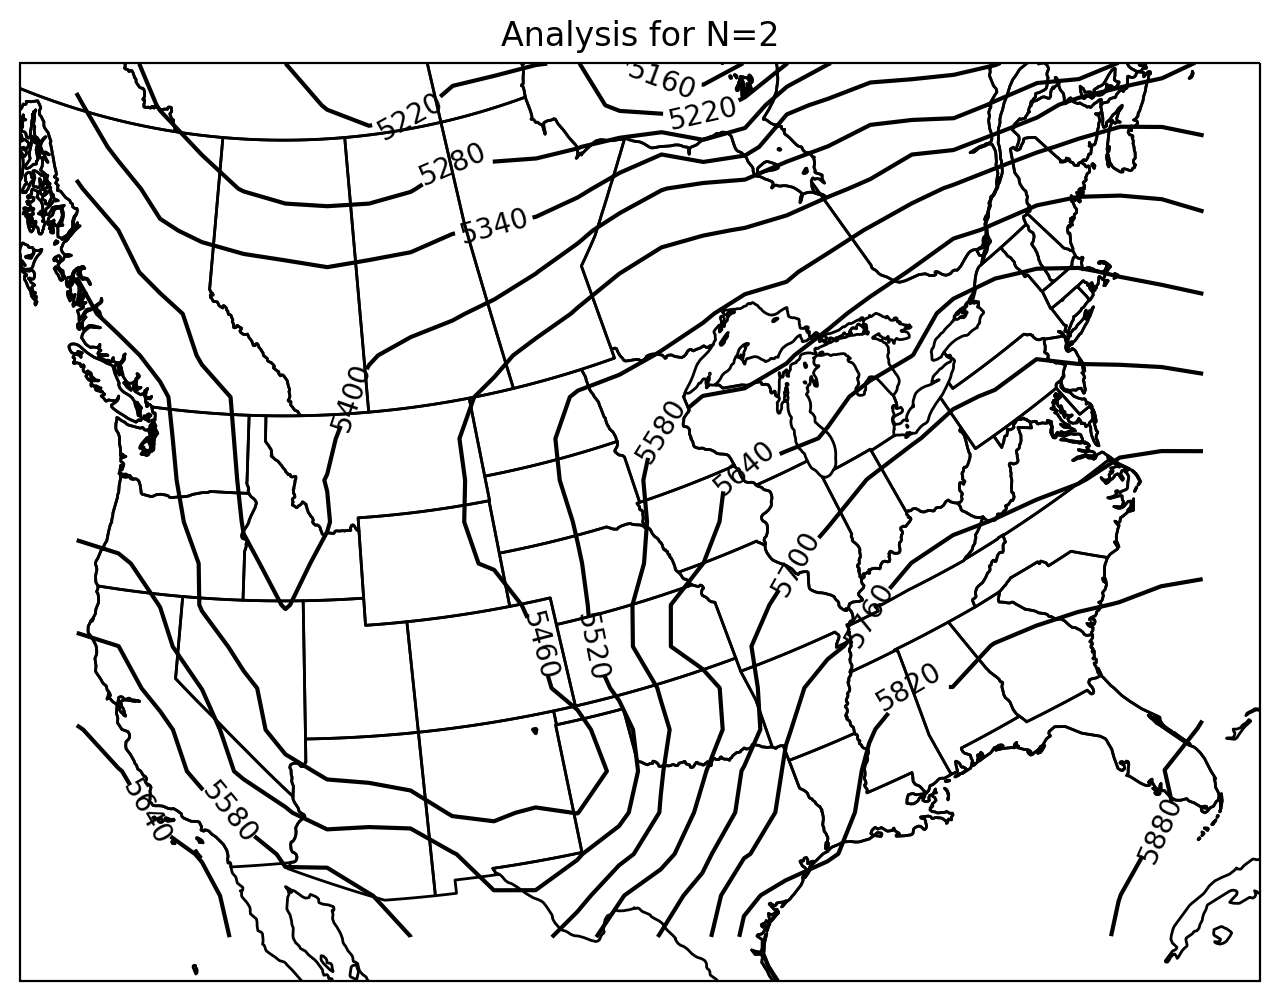

In [67]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,analysis_mx[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis for N=2')

plt.show()

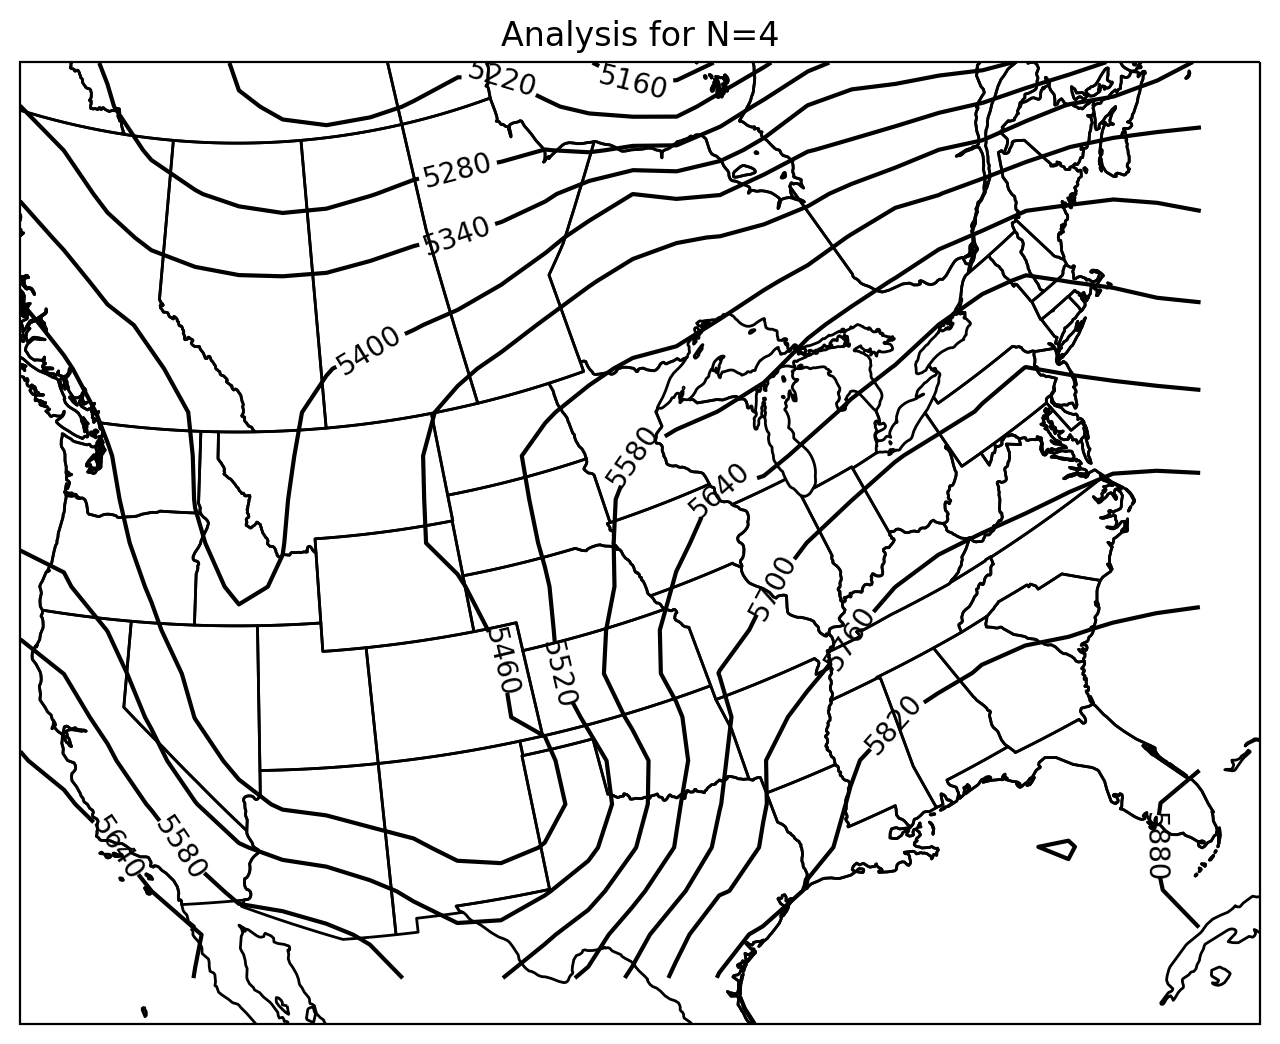

In [66]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,analysis_mx[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis for N=4')

plt.show()

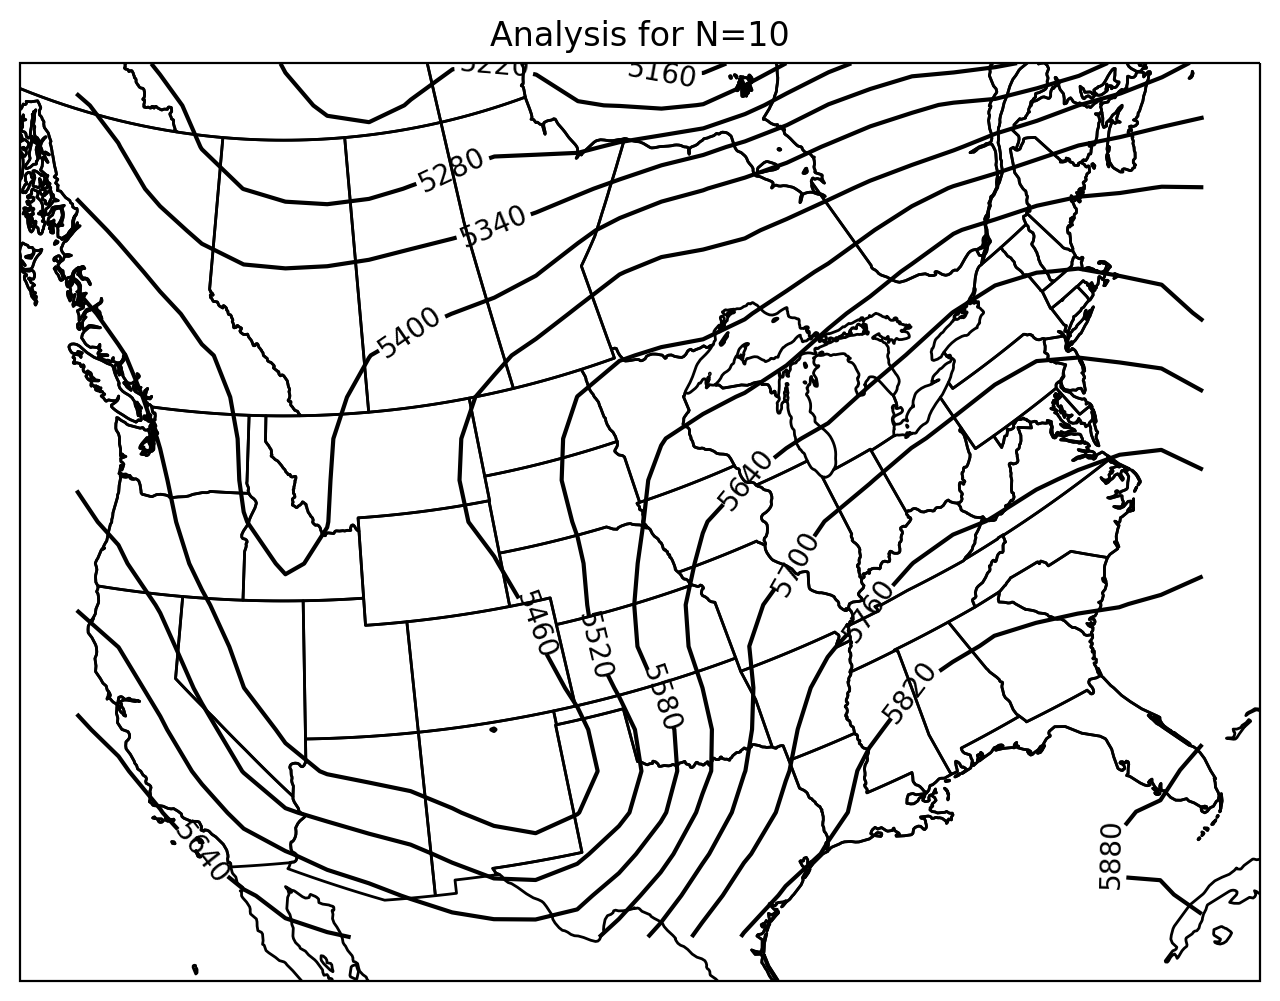

In [68]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,analysis_mx[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis for N=10')

plt.show()

In [27]:
#analysis increments
#fa-fb at analysis points
increment2 = analysis_mx[:,:,0] - f_a1
increment4 = analysis_mx[:,:,1] - f_a1
increment10 = analysis_mx[:,:,2] - f_a1

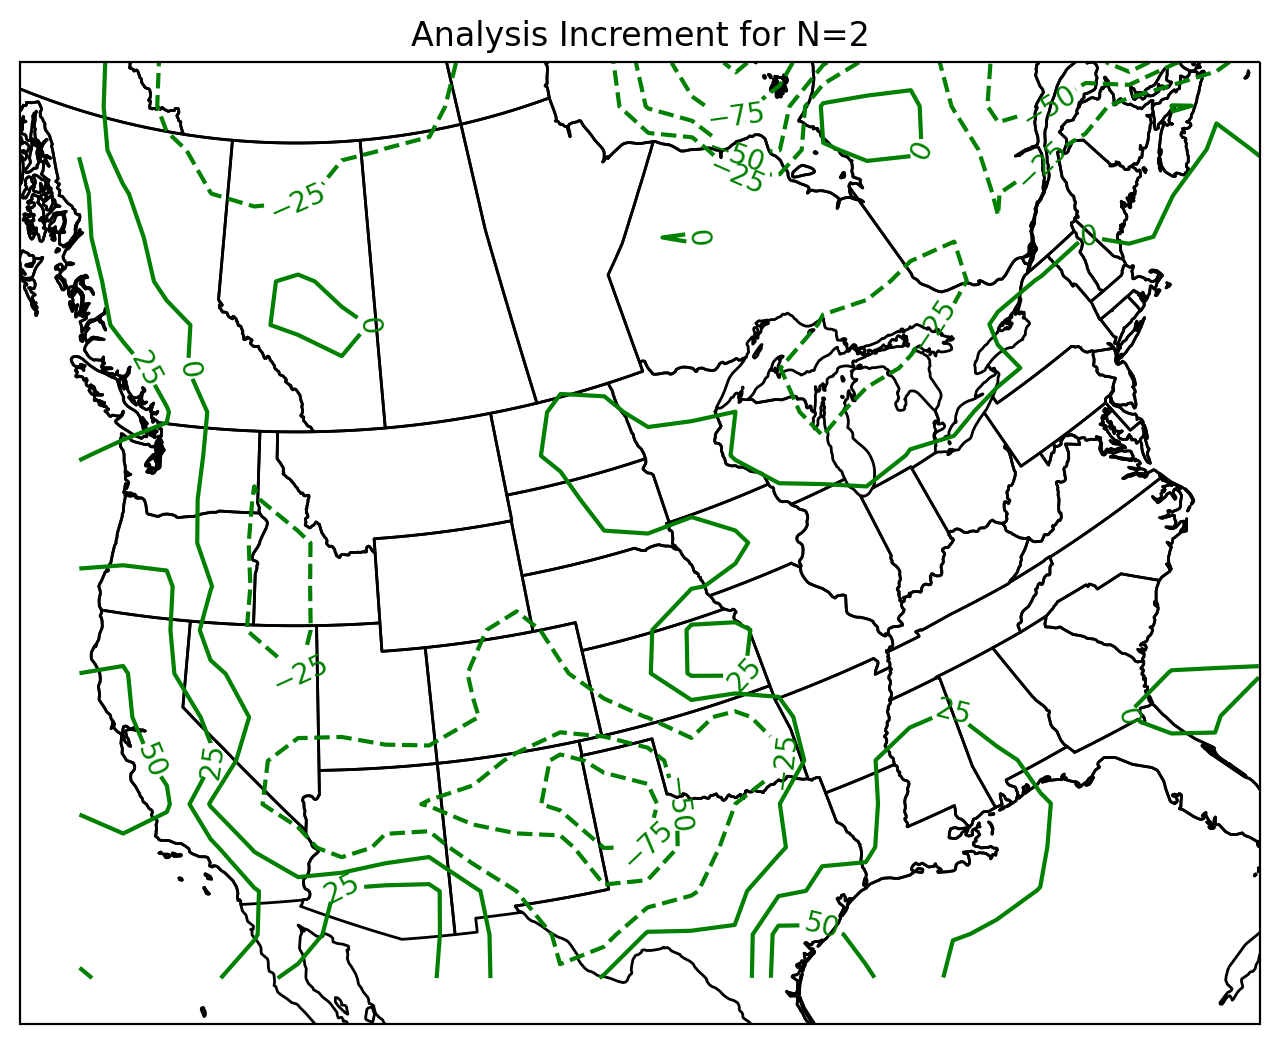

In [71]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,increment2,colors='green',levels=np.arange(-2000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-2000,8000,25))
plt.title('Analysis Increment for N=2')

plt.show()

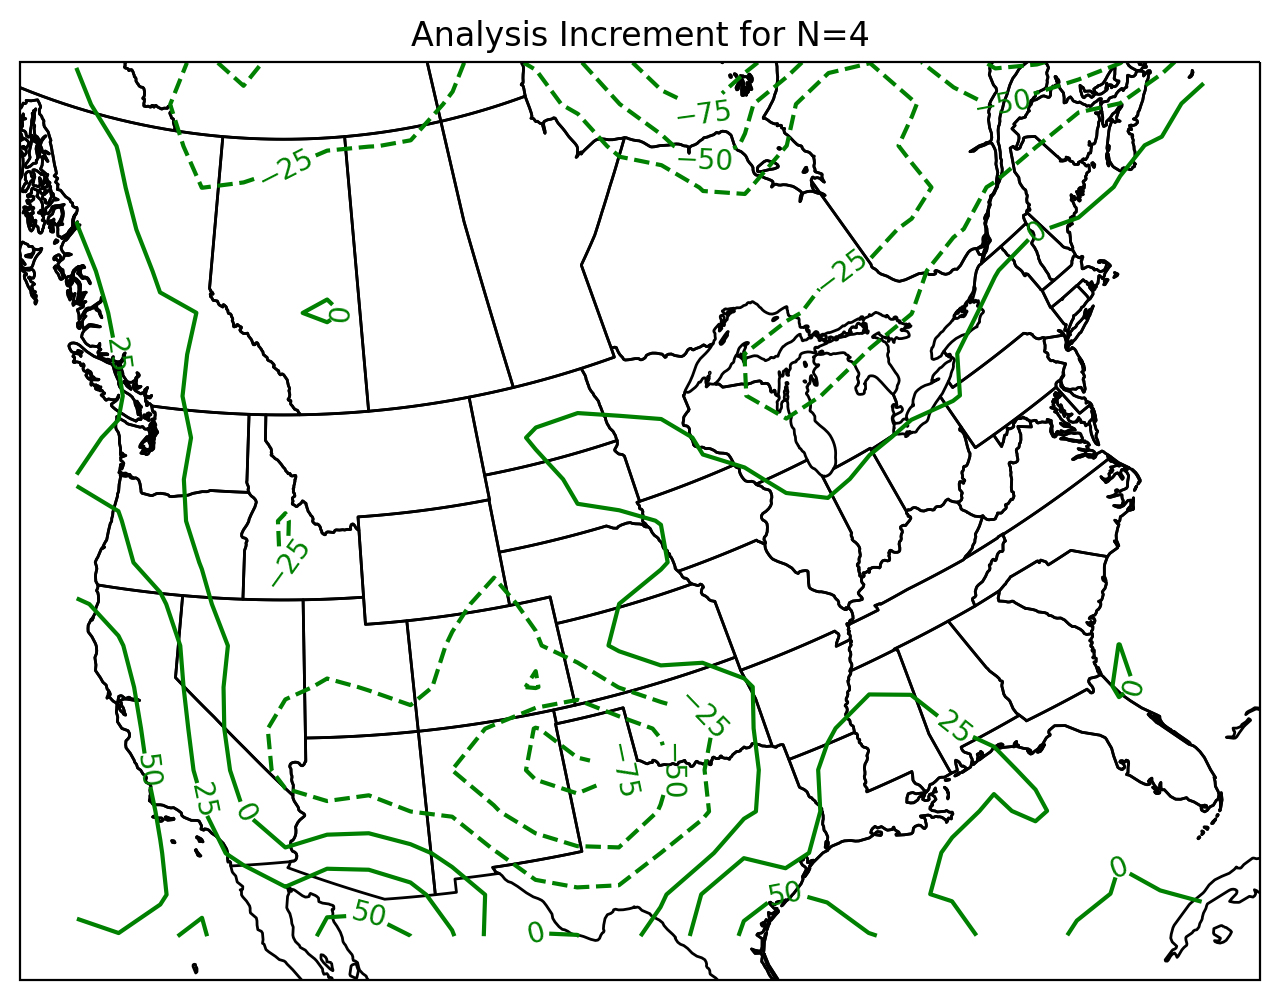

In [72]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,increment4,colors='green',levels=np.arange(-2000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-2000,8000,25))
plt.title('Analysis Increment for N=4')

plt.show()

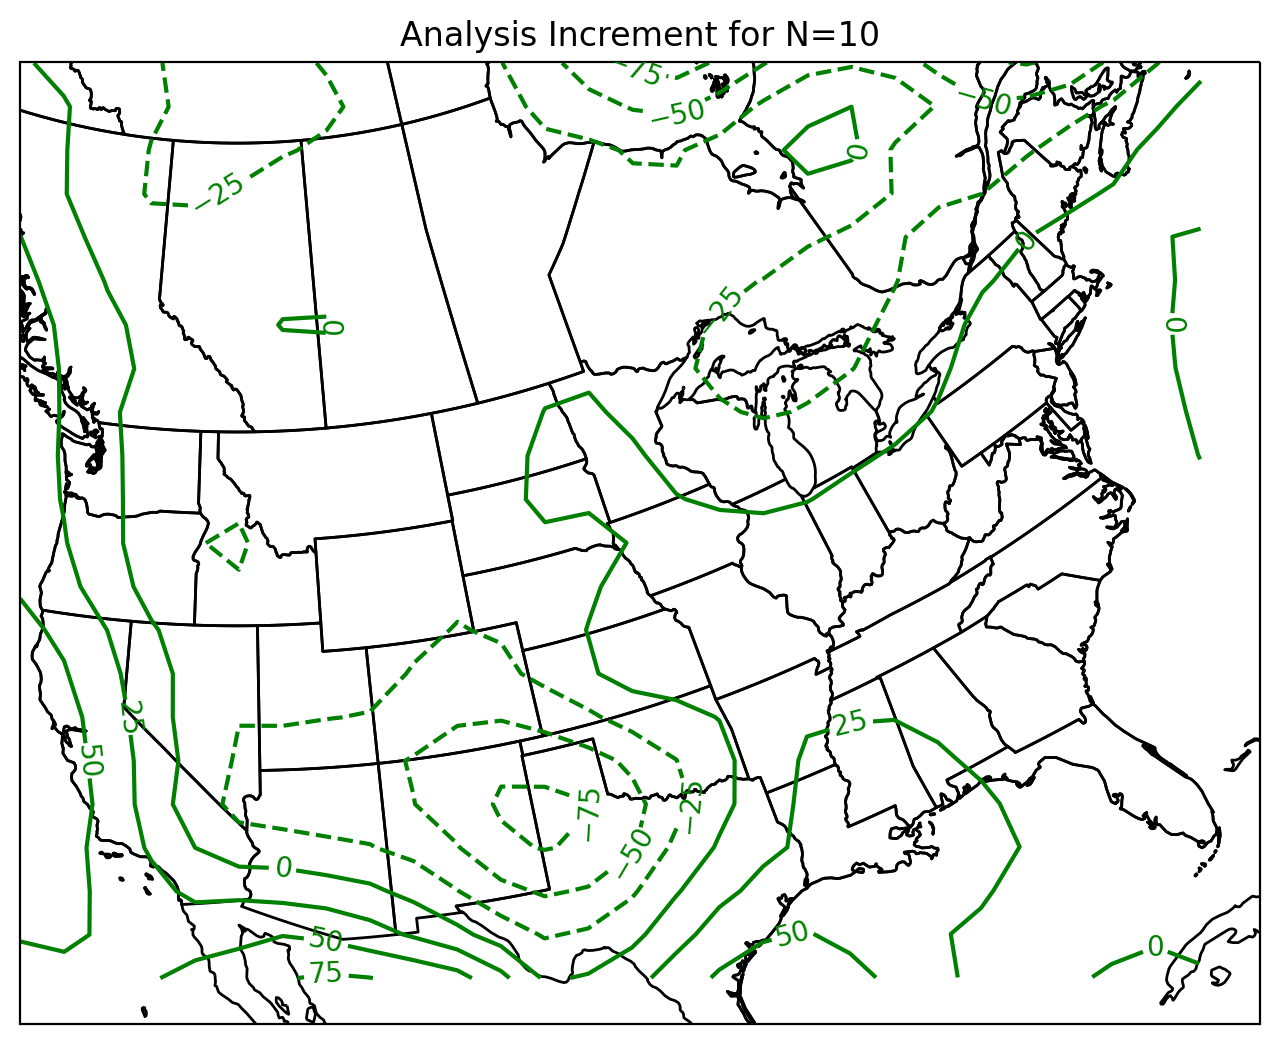

In [73]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x2lon,y2lat,increment10,colors='green',levels=np.arange(-2000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-2000,8000,25))
plt.title('Analysis Increment for N=10')

plt.show()

In [42]:
#find analysis values at observation points for each N
#check if ob loc is in grid, if yes-->bilin interp and if not-->reverse barnes
fa_rk = np.zeros((3,135))
indx = (x-18.9)/1.27
indy = (y+6.3)/1.27
for n in range(3):
    for idx in range(135): #for each observation point
        if indx[idx]>=0 and indy[idx]>=0 and indx[idx]<21 and indy[idx]<27: #if observation point is in grid
            fark = bilin_interp(indx[idx], indy[idx], analysis_mx[:,:,n]) #perform bilinear interp to find analysis value at that point


        else: #barnes
            xd = x[idx] - xx #ob point - grid points
            yd = y[idx] - yy

            #distance formula
            d_ik = ((xd**2 + yd**2)**.5) #28x22
            weights=np.zeros(xx.shape)
            want = np.where(d_ik<=r_e)

            for j in want[0]:
                for k in want[1]:
                    weights[j,k] = weight(d_ik[j,k])



            fark = np.sum(weights*analysis_mx[:,:,n])/np.sum(weights)
        fa_rk[n,idx] = fark  

C:\Users\taylo\AppData\Local\Temp\ipykernel_25428\1265844100.py:29: RuntimeWarning: invalid value encountered in double_scalars
  fark = np.sum(weights*analysis_mx[:,:,n])/np.sum(weights)


In [49]:
#compute analysis differences (analysis value minus observation value) at each station
obs = np.array(df['height'])
diff2 = fa_rk[0] - obs
diff4 = fa_rk[1] - obs
diff10 = fa_rk[2] - obs

In [55]:
#compute RMS differences between analysis values and observations at the observation stations.
diff2squared = (diff2)**2
diff2squared = diff2squared[~np.isnan(diff2squared)]
rms_2 = np.sqrt(np.sum(diff2squared/len(diff2squared)))

diff4squared = (diff4)**2
diff4squared = diff4squared[~np.isnan(diff4squared)]
rms_4 = np.sqrt(np.sum(diff4squared/len(diff4squared)))

diff10squared = (diff10)**2
diff10squared = diff10squared[~np.isnan(diff10squared)]
rms_10 = np.sqrt(np.sum(diff10squared/len(diff10squared)))

print('RMS for N=2: ', rms_2)
print('RMS for N=4: ', rms_4)
print('RMS for N=10: ', rms_10)

rms_vals=[rms_2, rms_4, rms_10]

### Store RMS values in text file ###
#np.savetxt('rms_vals.txt', rms_vals)


RMS for N=2:  51.91433649812192
RMS for N=4:  49.958482307273755
RMS for N=10:  50.970470312198664


In [61]:
### Store the difference fields in text files ###
differences = np.array((diff2,diff4,diff10))
'''
a_file = open("differences.txt", "w") #shape
for row in differences:
    np.savetxt(a_file, row)

a_file.close()
'''

In [62]:
### Store the analysis increments in text files ###
increments = np.array((increment2,increment4,increment10))
'''
a_file = open("increments.txt", "w") #shape
for row in increments:
    np.savetxt(a_file, row)

a_file.close()
'''

In [63]:
### Store the analyses in text files ###
'''
a_file = open("analysis_vals.txt", "w") 
for row in analysis_mx:
    np.savetxt(a_file, row)

a_file.close()
'''

In [10]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    
    There is a trough over the west and a ridge in the east for all three analyses.
    

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    The later analyses are smoother than the earlier ones and all maintain the same general pattern. The later analyses
    are smoother because more observations are considered at each grid point, meaning individual observations have
    less weight and smaller scale features are less visible. 


3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
    As the number of points considered increases, the analysis becomes smoother and smaller scale features become less
    visible. This is desirable if you are interested in larger scale features and observations are not perfect. If they
    are perfect, fewer points considered may be more desirable because the analysis will more closely resemble observations.
'''

'\n1 - Describe the general features that you see in your contoured analyses.\n    \n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n\n3 - What happens as you increase the number of points considered for the analysis?  Is this \n    desirable?  Why or why not?\n    \n'